<center><img src="data/itesm.png"/></center>
<h1 style='text-align: center;'><b>Maestría en Inteligencia Artificial Aplicada</b></h1>

<h2 style='text-align: center;'><b>Curso: Navegación autónoma</b></h2>
<h2 style='text-align: center;'><b>Tecnológico de Monterrey</b></h2>
<h2 style='text-align: center;'><b>Prof Titular y Tutor: Dr. David Antonio Torres</b></h2>
<h2 style='text-align: center;'><b>Prof Asistente: Maricarmen Vázquez Rojí</b></h2>

<h3 style='text-align: center;'><b>ALUMNO: </b>Luis Alfonso Sabanero Esquivel</h3>
<h3 style='text-align: center;'><b>MATRICULA: </b>A01273286</h3>
<h3 style='text-align: center;'><b>ALUMNO: </b>Jose Mtanous</h3>
<h3 style='text-align: center;'><b>MATRICULA: </b>A00169781</h3>
<h3 style='text-align: center;'><b>ALUMNO: </b> Guillermo Alfonso Muñiz Hermosillo</h3>
<h3 style='text-align: center;'><b>MATRICULA: </b>A01793101</h3>
<h3 style='text-align: center;'><b>ALUMNO: </b>Jorge Mariles Estrada</h3>
<h3 style='text-align: center;'><b>MATRICULA: </b>A01335663</h3>



<h2 style='text-align: center;'><b>Actividad de la Semana 07</b></h2>
<h2 style='text-align: center;'><b>Actividad 4.1 - Ejercicio de clasificación con Keras</b></h1>
<h4 style='text-align: right;'>Junio 2023</h4>

In [6]:
#Cargamos las librerias necesarias para trabajar con redes neuronales
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os
baseDir = 'data'
baseDir = '/home/jmtanous/temp'

Enseguida comenzamos con la importacion de datos. Para el caso de google drive tenemos que montar nuestro drive para poder ver los datos de nuestro dataset. 

En caso de contar con una implementacion local, necesitamos navegar al folder donde se encuentren nuestro dataset para comenzar a trabajar.

Una vez convertidas a formato jpg, importamos nuestras imagenes a un dataset utilizando la libreria de keras la cual nos permite establecer nuestros conjuntos de entrenamiento y validacion, asi como convertir nuestras imagenes a escala de grises y definir un tamaño de imagen y de batch, todo en un mismo comando.

In [7]:
image_size = (64, 32) #Variable necesaria para hacer el resize a la imagen
batch_size = 128  #Tamaño del lote

#La funcion opera de los siguientes parametros: 
#Ruta de las imagenes, tamaño del set de entrenamiento, requiere o no validatio set, semilla para random, como va a determinar los labels
#las dos variables de tamaño de imagen y tamaño de lote
#Como solo tenemos dos tipo de imagenes, se considera clasificación binaria
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    baseDir + "/Train",
    validation_split=0.2,
    subset="both",
    seed=1337,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    image_size=image_size,
    batch_size=batch_size,
)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Using 7841 files for validation.


In [8]:
test_metadata=pd.read_csv(baseDir + '/Test.csv')
y_test=test_metadata.ClassId.to_list()
nombres_test=test_metadata.Path.to_list()

In [33]:
image_size = (64, 32) #Variable necesaria para hacer el resize a la imagen
batch_size = 128  #Tamaño del lote
test_ds = tf.keras.utils.image_dataset_from_directory(
    baseDir + '/TPNG',
    seed=1337,
    validation_split=0,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    image_size=image_size,
    batch_size=batch_size,
)

NotFoundError: Could not find directory /home/jmtanous/temp/TPNG

In [11]:
#Probamos que el codigo funcione, vemos las caracteristicas del objeto
print(train_ds.take(1))


<_TakeDataset element_spec=(TensorSpec(shape=(None, 64, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 43), dtype=tf.float32, name=None))>


Una vez definido nuestro conjunto de datos podemos imprimir un subconjunto de nuestras imagenes y sus etiquetas para ver la data con la que estaremos trabajando.

2023-06-08 16:00:20.284114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [31368]
	 [[{{node Placeholder/_4}}]]
2023-06-08 16:00:20.284388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [31368]
	 [[{{node Placeholder/_4}}]]


labels: [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


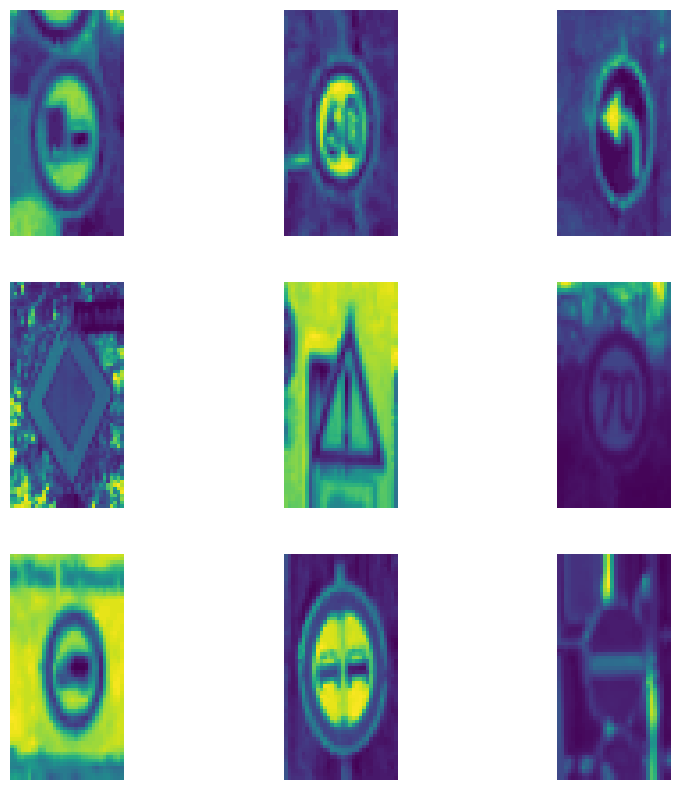

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    print("labels: {}".format(labels))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(int(labels[i]))
        plt.axis("off")

El siguiente paso sera ahora si construir nuestra red neuronal. En este paso es necesario jugar con los parametros por lo que al final mostraremos solo el modelo que consideramos entrega los mejores parametros.

In [27]:
target_shape=(64,32)

#Dado que usamos imagenes de 64x32, el numero de neuronas necesarias para la primera capa es de 2048
#Todas las capas usaran el metodo de activación Relu
#La capa de salida, usara el metodo de activación sigmoide al ser binaria la clasificación
#Usaremos dos capas de dropout para prevenir el sobreentrenamiento del modelo de 0.5
#Se aplicara un rescaling para normalizar todas las entradas y un flatten para hacer que la matriz sea unidimensional

#Importante: No usar un numero grande neuronas en local, problemas de memoria
model = tf.keras.Sequential([
#prepro layers
tf.keras.layers.Rescaling(1./255, input_shape=(image_size[0],image_size[1], 1)),
#training layers
tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0],image_size[1], 3)),
tf.keras.layers.MaxPooling2D((2, 2)),
tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
tf.keras.layers.MaxPooling2D((2, 2)),
tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
tf.keras.layers.Flatten(),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(43, activation="softmax"),
])

In [29]:
#Usaremos el metodo de optimización adam, junto con la funcion de perdida binarycrossentropy 
#La metrica de este modelo sera el accurancy
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
#Empezamos el entrenamiento, por mejores resultados se usaron 35 epocas
history=model.fit(train_ds, validation_data = val_ds, epochs = 15,)

Epoch 1/15
246/246 [==============================] - 3s 10ms/step - loss: 1.9739 - accuracy: 0.4837 - val_loss: 0.5890 - val_accuracy: 0.8546
Epoch 2/15
246/246 [==============================] - 2s 9ms/step - loss: 0.4808 - accuracy: 0.8643 - val_loss: 0.3886 - val_accuracy: 0.9111
Epoch 3/15
246/246 [==============================] - 2s 9ms/step - loss: 0.3354 - accuracy: 0.9046 - val_loss: 0.1980 - val_accuracy: 0.9564
Epoch 4/15
246/246 [==============================] - 2s 9ms/step - loss: 0.2114 - accuracy: 0.9407 - val_loss: 0.1523 - val_accuracy: 0.9659
Epoch 5/15
246/246 [==============================] - 2s 9ms/step - loss: 0.1639 - accuracy: 0.9550 - val_loss: 0.1343 - val_accuracy: 0.9730
Epoch 6/15
246/246 [==============================] - 2s 9ms/step - loss: 0.1344 - accuracy: 0.9614 - val_loss: 0.1182 - val_accuracy: 0.9751
Epoch 7/15
246/246 [==============================] - 2s 10ms/step - loss: 0.1121 - accuracy: 0.9684 - val_loss: 0.1005 - val_accuracy: 0.9790
Epoc

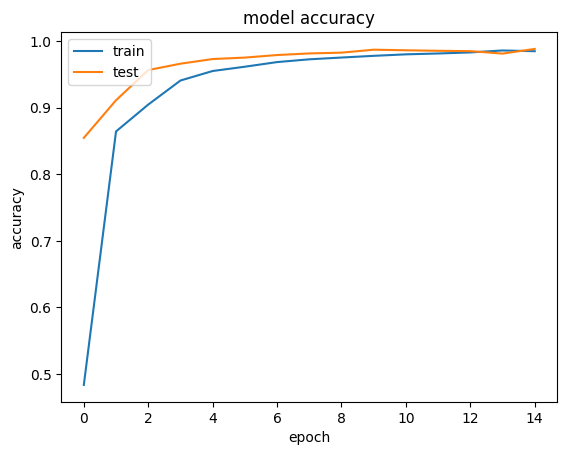

In [31]:
#Graficamos la evolución del entrenamiento 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
#Obtenemos imagenes de muestra para verificar las predicciones obtenida
images_full=[images for images, labels in val_ds.take(4)]
labels_full=[labels for images, labels in val_ds.take(4)]

2023-06-08 17:09:50.661656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7841]
	 [[{{node Placeholder/_4}}]]
2023-06-08 17:09:50.661856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7841]
	 [[{{node Placeholder/_4}}]]
2023-06-08 17:09:50.765860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7841]
	

In [24]:
#Imprimos algunas predicciones obtenidas por el modelo entrenado
cnt_samples=9
plt.figure(figsize=(10, 10))
batch= random.randint(1,val_ds.cardinality().numpy()-1) 
images=images_full[batch]
labels=labels_full[batch]
predictions = model.predict(images).round() #Pasamos el grupo de imagenes obtenidas para predecir
l_items=[x for x in range(predictions.shape[0])]
sample_=random.sample(l_items,cnt_samples)


for tile,i in enumerate(sample_):
    ax = plt.subplot(3, 3, tile + 1)

    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(f'y={int(labels[i])}, yhat={int(predictions[i])}')
    plt.axis("off")

IndexError: list index out of range

<Figure size 1000x1000 with 0 Axes>